In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import random
from numba import jit
import pickle

# params

In [17]:
# stim params
ABL_arr = [20]
ILD_arr = [0]

# Model params
rate_lambda = 0.076
theta_E = 50.7
T_0 = 0.19*(1e-3)
t_non_decision = 78e-3

V_A = 1
theta_A = 1

# t_stim = 0.25
# t_A_aff = 0.01
# t_E_aff = 0.02
# t_motor = 0.03

t_stim = 0; t_A_aff = 0; t_E_aff = 0; t_motor = 0

Z_E = 0

# prob map from DV to hit bound
# L = 0.0001
L = 1

# sim params
N_sim = int(5e6)
dt = 1e-4

# fitting params
K_max = 10

# map func

In [18]:
def DV_to_prob_hit_up_map(DV, L):
    """
    A linear map that transforms DV[0,2] to probability of hitting upper bound 
    L^-1 is the slope of the line
    The line is such that y(1 + L/2) = 1 and y(1 - L/2) = 0 and y(1) = 0.5
    """
    if DV > 1 + (L/2):
        return 1
    
    if DV < 1 - (L/2):
        return 0
    
    return (1/L)*DV + (0.5 - (1/L))

# data gen func

In [19]:
def psiam_tied_data_gen_wrapper(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    choice, rt, is_act = simulate_psiam_tied(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD}

@jit
def simulate_psiam_tied(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, dt):
    AI = 0; DV = Z_E; t = 0; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    
    is_act = 0
    while True:
        if t*dt > t_stim + t_E_aff:
            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        if t*dt > t_A_aff:
            AI += V_A*dt + np.random.normal(0, dB)
        
        t += 1
        
        if DV >= theta:
            choice = +1; RT = t*dt + t_motor
            break
        elif DV <= -theta:
            choice = -1; RT = t*dt + t_motor
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t*dt
            # if t*dt > t_stim - t_motor:
            while t*dt <= (AI_hit_time + t_E_aff + t_motor):#  u can process evidence till stim plays
                if t*dt > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        break
                    elif DV <= -theta:
                        DV = -theta
                        break
                t += 1
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time + t_motor
        if DV != 0:
            if DV > 1 + (L/2):
                choice = 1
            elif DV < 1 - (L/2):
                choice = -1
            else:
                prob_hit_up = (1/L)*DV + (0.5 - (1/L))            
                if np.random.rand() <= prob_hit_up:
                    choice = 1
                else:
                    choice = -1
        # if DV > 0:
        #     choice = 1
        # elif DV < 0:
        #     choice = -1
        else: # if DV is 0 because stim has not yet been played, then choose right/left randomly
            randomly_choose_up = np.random.rand() >= 0.5
            if randomly_choose_up:
                choice = 1
            else:
                choice = -1       
    
    return choice, RT, is_act


# gen data

In [20]:
# with open('data_psiam_with_tied_dv_map.pkl', 'rb') as f:
#     sim_results = pickle.load(f)

In [21]:
sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                        rate_lambda, T_0, theta_E, Z_E, \
                                                                            t_stim, t_A_aff, t_E_aff, t_motor, L, dt)\
                                                                                  for _ in range(N_sim))
# parse results
all_choice = np.array([res['choice'] for res in sim_results])
all_RT = np.array([res['rt'] for res in sim_results])
all_is_act = np.array([res['is_act'] for res in sim_results])


print(f"% of AI process = {100*np.sum(all_is_act)/N_sim}")
print(f"Num of Aborts = {np.sum(all_RT < t_stim)}")
print(f"Num of up hits = {np.sum(all_choice == 1)}, Num of down hits = {np.sum(all_choice == -1)}")

% of AI process = 9.61774
Num of Aborts = 0
Num of up hits = 2492710, Num of down hits = 2507290


# fit all RT

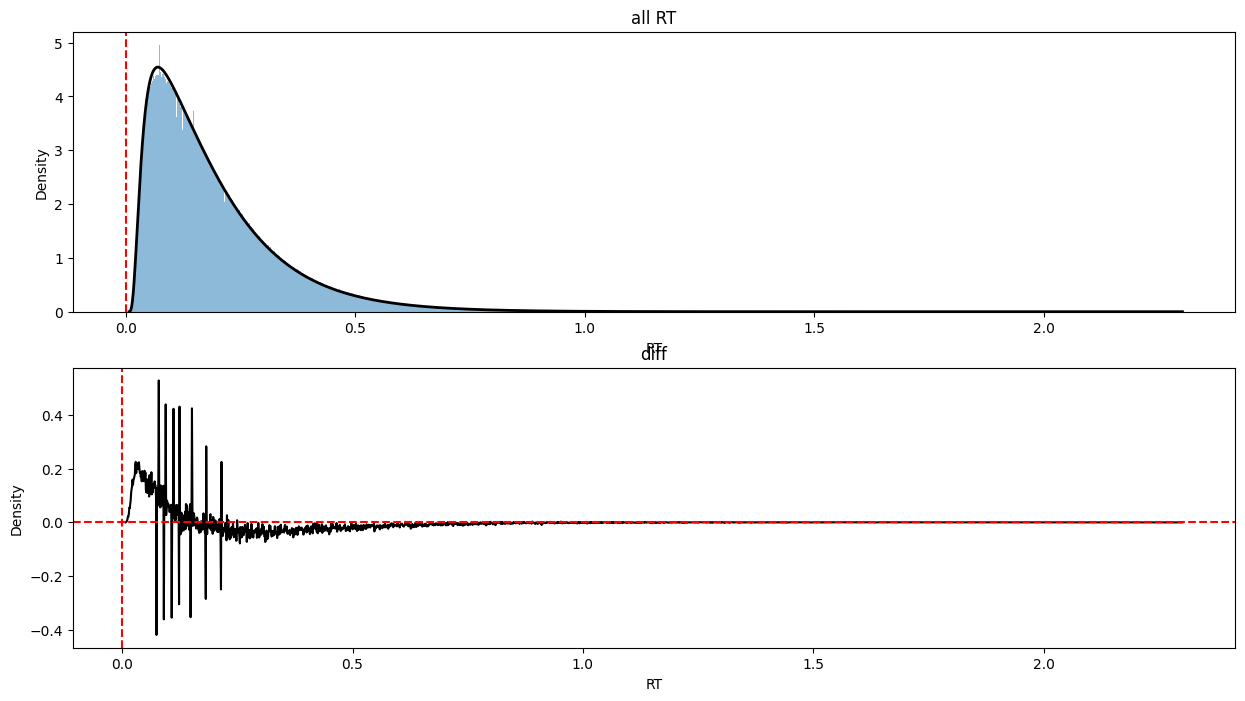

In [22]:
from psiam_tied_utils import all_RTs_fit_fn

# stim
ABL = ABL_arr[0]; ILD = ILD_arr[0]

# bins
bin_width = 0.001  
bins = np.arange(min(all_RT), max(all_RT) + bin_width, bin_width)

# t_pts are midpoints of the bins
t_pts = bins[:-1] + bin_width/2
theory = all_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

all_hist, all_bins = np.histogram(all_RT, bins=bins, density=True)

plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(all_bins[:-1], all_hist, width=bin_width, alpha=0.5, label='all RT')
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, theory, 'k', lw=2);
plt.title('all RT');plt.xlabel('RT');plt.ylabel('Density');

plt.subplot(2,1,2)
diff_all = theory - all_hist 
plt.plot(t_pts, diff_all, 'k');
plt.title('diff');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--');


# fit up rt

In [23]:
from scipy.special import erf

def integral_of_exp_term_times_x(x, A, B):
    """
    Integral of exp(-(x+A)^2 / B) * x * dx 
    """
    return (-B/2)*np.exp( -((x + A)**2)/B ) - (A*np.sqrt(np.pi*B)/2)*erf( (x + A)/np.sqrt(B) )

def integral_of_exp_term(x, A, B):
    """
    Integral of exp(-(x+A)^2 / B) * dx
    """
    return (np.sqrt(np.pi*B)/2) * erf( (x + A)/np.sqrt(B) )

def Phi(x):
    """
    Define the normal cumulative distribution function Φ(x) using erf
    """
    return 0.5 * (1 + erf(x / np.sqrt(2)))

def P_small_t_btn_x1_x2(x1, x2, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max):
    """
    Integration of P_small(x,t) btn x1 and x2
    """
    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E*q_e

    chi = 17.37
    mu = theta_E * np.tanh(rate_lambda * ILD / chi)
    z = (Z_E/theta) + 1.0

    
    t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    t /= t_theta

    result = 0
    
    sqrt_t = np.sqrt(t)
    
    for n in range(-K_max, K_max + 1):
        term1 = np.exp(4 * mu * n) * (
            Phi((x2 - (z + 4 * n + mu * t)) / sqrt_t) -
            Phi((x1 - (z + 4 * n + mu * t)) / sqrt_t)
        )
        
        term2 = np.exp(2 * mu * (2 * (1 - n) - z)) * (
            Phi((x2 - (-z + 4 * (1 - n) + mu * t)) / sqrt_t) -
            Phi((x1 - (-z + 4 * (1 - n) + mu * t)) / sqrt_t)
        )
        
        result += term1 - term2
    
    return result

def prob_x_t_and_hit_up_analytic(t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, L, N_max):
    """
    Given x and t, return the probability of hitting the upper bound
    """

    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E*q_e

    chi = 17.37
    mu = theta_E * np.tanh(rate_lambda * ILD / chi)
    z = (Z_E/theta) + 1.0
    
    t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    t /= t_theta


    term1 = 1/np.sqrt(2*np.pi*t)
    n_terms = np.linspace(-N_max, N_max, 2*N_max+1)

    m = 1/L
    c = 0.5 - 1/L
    
    sum_term = 0
    B = 2*t

    for n in n_terms:
        exp1 = np.exp(4*mu*n)
        A1 = -z - 4*n - mu*t

        exp2 = np.exp(2*mu*(2 - 2*n - z))
        A2 = z - 4*(1-n) - mu*t


        # exp_term * exp((x + A)**2 / B ) * mx +  exp_term * exp((x + A)**2 / B ) * c
        sum_term += exp1*m*integral_of_exp_term_times_x(1+(L/2), A1, B) + exp1*c*integral_of_exp_term(1+(L/2), A1, B) \
                    - exp2*m*integral_of_exp_term_times_x(1+(L/2), A2, B) - exp2*c*integral_of_exp_term(1+(L/2), A2, B) \
                    - (
                        exp1*m*integral_of_exp_term_times_x(1-(L/2), A1, B) + exp1*c*integral_of_exp_term(1-(L/2), A1, B) \
                        - exp2*m*integral_of_exp_term_times_x(1-(L/2), A2, B) - exp2*c*integral_of_exp_term(1-(L/2), A2, B)

                        )
        
    
    return term1*sum_term  + P_small_t_btn_x1_x2(1+L/2, 2, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)

In [24]:
from psiam_tied_utils import rho_A_t_fn, CDF_E_minus_small_t_NORM_fn, rho_E_minus_small_t_NORM_fn, cum_A_t_fn
def up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max):
    """
    PDF of up RTs array
    """
    bound = 1

    P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) for t in t_pts]
    P_EA_btn_1_2 = [prob_x_t_and_hit_up_analytic(t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, L, K_max) for t in t_pts]
    P_E_plus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_motor - t_stim - t_E_aff
        t2 = t - t_stim
        if t1 < 0:
            t1 = 0
        P_E_plus_cum[i] = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) \
                    - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)


    P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm

In [25]:
up_rt_idx = np.where(all_choice == 1)[0]
up_rt = all_RT[up_rt_idx]

non_abort_up_rt_idx = np.where(up_rt > t_stim)[0]
up_rt = up_rt[non_abort_up_rt_idx]

bin_width = 0.001
min_rt = np.min(up_rt)
max_rt = np.max(up_rt)

# hist
bins = np.arange(min_rt, max_rt + bin_width, bin_width)
up_hist, up_bins = np.histogram(up_rt, bins=bins, density=True)
up_hist *= len(up_rt)/( len(all_RT) )

# theory
t_pts = bins[:-1] + bin_width/2
ABL = ABL_arr[0]; ILD = ILD_arr[0]
up_theory = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L,  K_max)

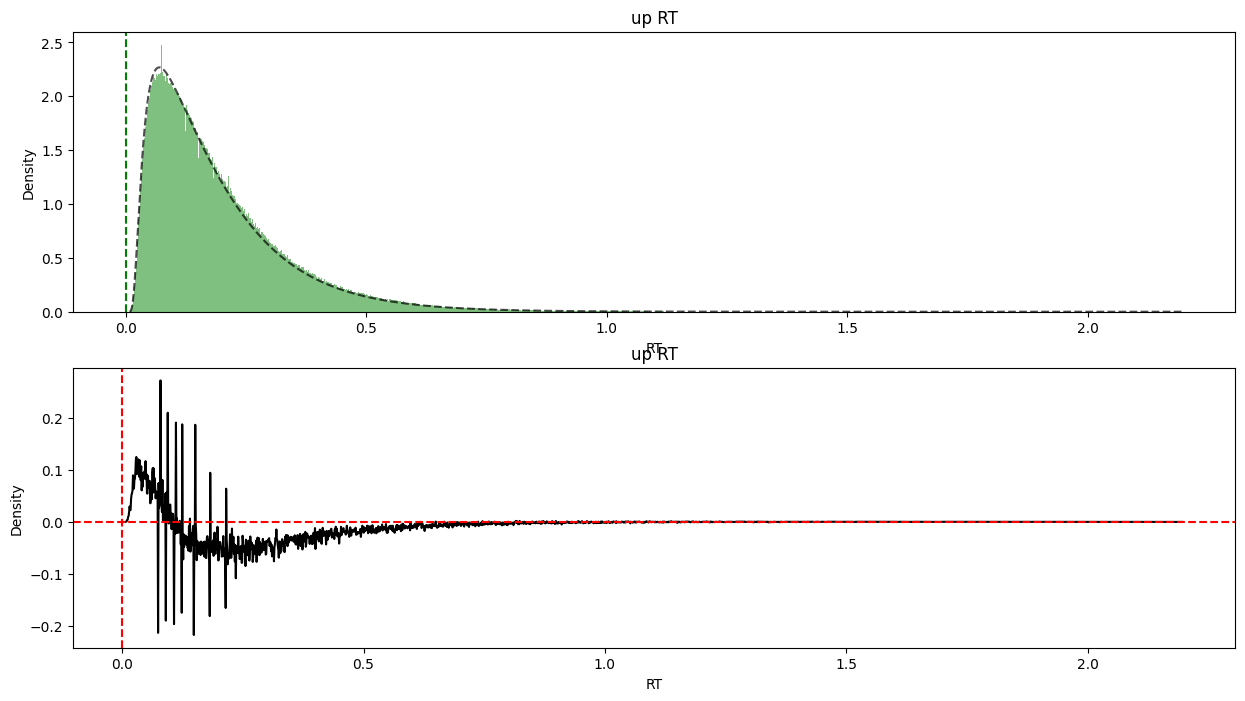

In [26]:
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(up_bins[:-1], up_hist, width=bin_width, color='g', alpha=0.5)
plt.axvline(x=t_stim, color='g', linestyle='--')
plt.plot(t_pts, up_theory, linestyle='--', color='k', alpha=0.7);
plt.xlabel('RT');plt.ylabel('Density');plt.title('up RT');
# plt.xlim([0.2, 1])

plt.subplot(2,1,2)
diff_up = up_theory - up_hist
plt.plot(t_pts, diff_up, 'k');
plt.title('up RT');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--');
# plt.xlim([0.2, 1]);

# fit down rt

In [27]:
def prob_x_t_and_hit_down_analytic(t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, L, N_max):
    """
    Given x and t, return the probability of hitting the upper bound
    """

    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E*q_e

    chi = 17.37
    mu = theta_E * np.tanh(rate_lambda * ILD / chi)
    z = (Z_E/theta) + 1.0
    
    t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    t /= t_theta


    term1 = 1/np.sqrt(2*np.pi*t)
    n_terms = np.linspace(-N_max, N_max, 2*N_max+1)

    m = -1/L
    c = 0.5 + 1/L
    
    sum_term = 0
    B = 2*t

    for n in n_terms:
        exp1 = np.exp(4*mu*n)
        A1 = -z - 4*n - mu*t

        exp2 = np.exp(2*mu*(2 - 2*n - z))
        A2 = z - 4*(1-n) - mu*t


        # exp_term * exp((x + A)**2 / B ) * mx +  exp_term * exp((x + A)**2 / B ) * c
        sum_term += exp1*m*integral_of_exp_term_times_x(1+(L/2), A1, B) + exp1*c*integral_of_exp_term(1+(L/2), A1, B) \
                    - exp2*m*integral_of_exp_term_times_x(1+(L/2), A2, B) - exp2*c*integral_of_exp_term(1+(L/2), A2, B) \
                    - (
                        exp1*m*integral_of_exp_term_times_x(1-(L/2), A1, B) + exp1*c*integral_of_exp_term(1-(L/2), A1, B) \
                        - exp2*m*integral_of_exp_term_times_x(1-(L/2), A2, B) - exp2*c*integral_of_exp_term(1-(L/2), A2, B)

                        )
        
    
    return term1*sum_term  + P_small_t_btn_x1_x2(0, 1 - L/2, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)

In [28]:
def prob_x_t_and_hit_down_numeric(x, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, L, K_max):
    
    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E*q_e

    chi = 17.37
    mu = theta_E * np.tanh(rate_lambda * ILD / chi)
    z = (Z_E/theta) + 1.0
    
    t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    t /= t_theta


    
    term1 = 1/(2*np.pi*t)**0.5    
    k_terms = np.linspace(-K_max, K_max, 2*K_max+1)
    exp_1 = np.exp(4*mu*k_terms - (((x - z - 4*k_terms - mu*t)**2)/(2*t)))
    exp_2 = np.exp(2*mu*(2 - 2*k_terms - z) - ((x + z - 4 + 4*k_terms - mu*t)**2)/(2*t))
    exp_diff = exp_1 - exp_2


    m = -1/L
    c = 0.5 + 1/L

    return term1*np.sum(exp_diff)*(m*x + c)

In [29]:
from scipy.integrate import quad

def down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max):
    """
    PDF of down RTs array
    """
    bound = -1
        
    P_A = [rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) for t in t_pts]
    P_EA_btn_0_1 = [prob_x_t_and_hit_down_analytic(t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, L, K_max) for t in t_pts]
    # P_EA_btn_0_1 = [quad(prob_x_t_and_hit_down_numeric, 1 - L/2, 1 + L/2, args=(t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, L, K_max))[0] + P_small_t_btn_x1_x2(0, 1 - L/2, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max) for t in t_pts]
    P_E_minus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_motor - t_stim - t_E_aff
        t2 = t - t_stim
        # if t1 < 0:
        #     t1 = 0
        P_E_minus_cum[i] = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) \
                    - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)


    P_E_minus = [rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_0_1 = np.array(P_EA_btn_0_1); P_E_minus = np.array(P_E_minus); C_A = np.array(C_A)
    P_wrong_unnorm = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))
    return P_wrong_unnorm

In [30]:
down_rt_idx = np.where(all_choice == -1)[0]
down_rt = all_RT[down_rt_idx]

non_abort_down_rt_idx = np.where(down_rt > t_stim)[0]
down_rt = down_rt[non_abort_down_rt_idx]

ABL = ABL_arr[0]; ILD = ILD_arr[0]


bin_width = 0.001
min_rt = np.min(down_rt)
max_rt = np.max(down_rt)
bins = np.arange(min_rt, max_rt + bin_width, bin_width)

down_hist, down_bins = np.histogram(down_rt, bins=bins, density=True)
down_hist *= len(down_rt)/( len(all_RT))


t_pts = bins[:-1] + bin_width/2
down_theory = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)

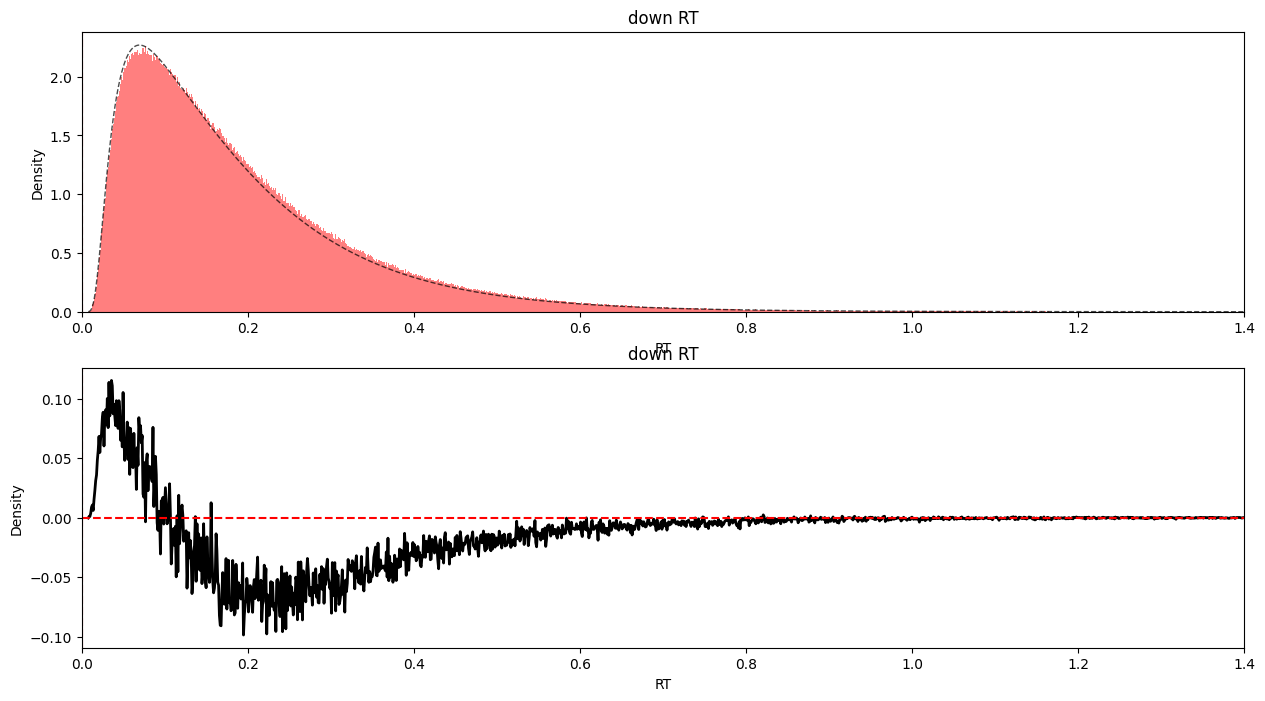

In [31]:
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(down_bins[:-1], down_hist, width=bin_width, color='r', alpha=0.5)
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, down_theory, 'k', lw=1, linestyle='--', alpha=0.7);
plt.xlim([0, 1.4]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('down RT');

plt.subplot(2,1,2)
diff_down = down_theory - down_hist
plt.plot(t_pts, diff_down, 'k', lw=2);
plt.title('down RT');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--') 
plt.xlim([0, 1.4]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('down RT');
